# Testing Navier-Stokes with a body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Dyn3d"), "src/Dyn3d.jl"))
using Dyn3d
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body. Here is a plate:

In [4]:
n = 50;
body = Bodies.NACA4(0.0,0.0,0.15,np=n);

In [5]:
ds = Bodies.dlength(body);


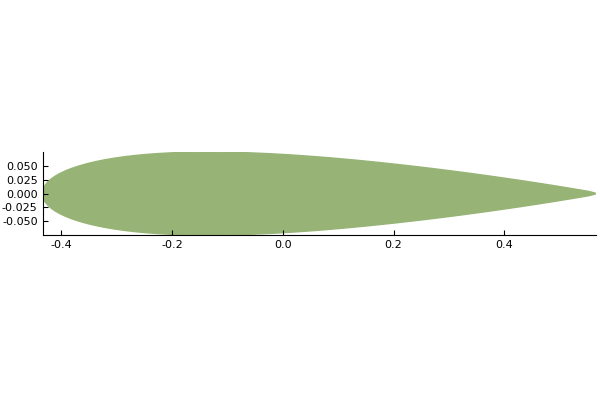

In [6]:
plot(body)

Set the body motion. Make it stationary.

In [7]:
motion = RigidBodyMotion(0.0,0.0)

Rigid Body Motion:
  ċ = 0.0 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Constant (ċ = 0.0 + 0.0im, α̇ = 0.0)

Transform the body with a specified initial position and orientation.

In [8]:
cent = (1.0,1.0) #1.0+1.0im
α = -π/4 #-π/4
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Whirl.Bodies.NACA4{99}(1.0, 0.0, 0.0, 0.15, (1.0, 1.0), -0.7853981633974483, [0.565653, 0.562053, 0.551998, 0.537357, 0.519685, 0.499676, 0.477777, 0.454319, 0.429561, 0.403716  …  0.376968, 0.403716, 0.429561, 0.454319, 0.477777, 0.499676, 0.519685, 0.537357, 0.551998, 0.562053], [2.72255e-18, 0.00141604, 0.00394545, 0.00644564, 0.00940583, 0.0126837, 0.016184, 0.0198359, 0.0235839, 0.0273832  …  -0.0311963, -0.0273832, -0.0235839, -0.0198359, -0.016184, -0.0126837, -0.00940583, -0.00644564, -0.00394545, -0.00141604], [1.39998, 1.39843, 1.39311, 1.38453, 1.37412, 1.36229, 1.34928, 1.33528, 1.32042, 1.30483  …  1.2445, 1.26611, 1.28707, 1.30723, 1.3264, 1.34436, 1.36082, 1.37541, 1.38753, 1.39643], [0.600023, 0.60357, 0.612468, 0.624589, 0.639178, 0.655644, 0.673604, 0.692774, 0.712931, 0.733892  …  0.711384, 0.695167, 0.679578, 0.664722, 0.650716, 0.637707, 0.625876, 0.615474, 0.606889, 0.601567])

Set up the domain

In [9]:
xlim = (0.0,4.0)
ylim = (0.0,2.0)

(0.0, 2.0)


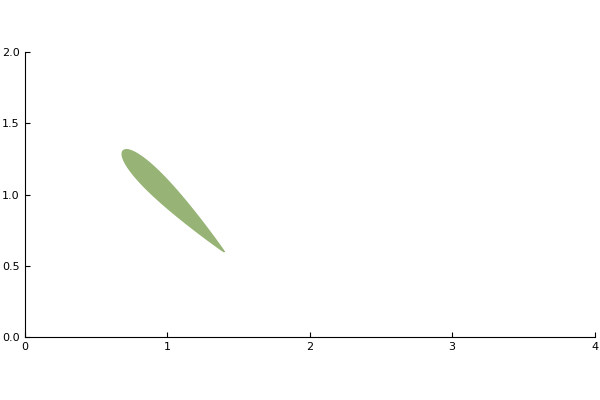

In [10]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [11]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [12]:
nx = 202; ny = 102;
Ly = ylim[2]-ylim[1];
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
Δt = Δt / 100
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [13]:
u = w₀
f = VectorData(X̃);
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

Set up the integrator here

In [14]:
ifherk = IFHERK(u,f,sys.Δt,
                (t,u) -> plan_intfact(t,u,sys),
                (u,t) -> plan_constraints(u,t,sys),
                ((u,t) -> Whirl.TimeMarching.r₁(u,t,sys),
                 (u,t) -> Whirl.TimeMarching.r₂(u,t,sys)),rk=RK31)

[1.0, 0.5, 0.0, 0.0]


Order-3+ IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{99}
   Time step size 0.0001


Initialize the state vector and the history vectors

In [15]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.01; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [16]:
tf = 0.2;
T = Δt:Δt:tf;
# T = Δt:Δt:2Δt;

In [17]:
@time for ti in T
    t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

stage 1
force x [-1.70003e6, 1.18344e8, -3.47666e8, 5.32538e8, -5.83496e8, 5.49822e8, 1.80593e9, -4.85252e9, 4.47641e9, -2.74833e9, 1.47708e9]

acceleration [-10390.6, -17.8631, -1.34105, -0.00227468, -1.83054e-6, -9.46202e-10, 6.54586e-13, 9.60534e-13]

vorticity [-0.519372, -0.000218917, -3.29341e-5, -2.04879e-8, 8.36356e-13, 5.88939e-15, 5.17649e-17, 7.55629e-17]

stage 2
force x [3.09903e5, -2.15214e7, 6.3234e7, -9.68833e7, 1.06186e8, -1.00114e8, -3.28284e8, 8.82412e8, -8.1412e8, 4.99911e8, -2.68703e8]

acceleration [1890.08, -1.22157, -1.06328, -0.00130557, -2.22494e-7, 5.15742e-10, 3.0666e-13, 1.76905e-13]

vorticity [-0.520018, -0.00108296, -0.000122365, -1.86509e-7, -1.1509e-10, -3.28311e-14, 5.07535e-17, 6.29334e-17]

stage 3
force x [8.57687e5, -5.88946e7, 1.73003e8, -2.65018e8, 2.90409e8, -2.73717e8, -8.98301e8, 2.41415e9, -2.22717e9, 1.36748e9, -7.34979e8]

acceleration [5172.44, -7.12294, -1.18618, -0.000536515, 1.38268e-6, 1.41405e-9, 4.29223e-13, 1.82048e-15]

vorticity 

stage 3
force x [-3714.98, 90509.0, -2.4961e5, 3.57157e5, -3.60077e5, 2.8854e5, 1.41454e6, -3.53039e6, 3.1675e6, -1.87646e6, 9.83659e5]

acceleration [-7.93089, -1.80641, -1.20747, 0.00630886, 0.00021119, -4.12555e-7, 1.7352e-9, -6.32581e-12]

vorticity [-0.528252, -0.012455, -0.00153604, -1.08412e-5, 1.61854e-8, -4.9528e-11, 2.45695e-13, -5.96099e-16]

------------------------------
stage 1
force x [-3716.33, 90745.8, -2.50308e5, 3.5822e5, -3.61241e5, 289618.0, 1.41842e6, -3.54063e6, 3.1769e6, -1.88221e6, 9.86748e5]

acceleration [-7.93617, -1.81543, -1.20687, 0.00504472, 0.000237149, -1.93412e-7, 1.99944e-9, -6.68177e-12]

vorticity [-0.528775, -0.0131985, -0.00164129, -1.21132e-5, 2.05633e-8, -5.92975e-11, 3.38045e-13, -7.96363e-16]

stage 2
force x [-3686.33, 90580.7, -2.49895e5, 3.57622e5, -3.60608e5, 2.89096e5, 1.41586e6, -3.53426e6, 3.17118e6, -1.87881e6, 9.84959e5]

acceleration [-7.91714, -1.80945, -1.20879, 0.00635262, 0.000251645, -4.2322e-7, 2.51624e-9, -9.89763e-12]

vorti

stage 2
force x [-3333.14, 89709.1, -2.48235e5, 3.5557e5, -3.58707e5, 2.88397e5, 1.40112e6, -3.50188e6, 3.14359e6, -1.86339e6, 9.77176e5]

acceleration [-7.74443, -1.78164, -1.2313, 0.0168849, 0.00076049, -4.97213e-6, 6.22107e-8, -5.08382e-10]

vorticity [-0.536313, -0.0241974, -0.00331125, -3.85504e-5, 1.72957e-7, -1.62266e-9, 1.87302e-11, -1.12358e-13]

stage 3
force x [-3311.35, 89516.3, -2.47724e5, 3.54828e5, -3.57924e5, 2.87761e5, 1.39775e6, -3.49356e6, 3.13611e6, -1.85893e6, 9.74816e5]

acceleration [-7.73324, -1.77475, -1.23325, 0.0183193, 0.000777343, -5.90574e-6, 7.27092e-8, -6.21296e-10]

vorticity [-0.536313, -0.024197, -0.00331136, -3.84674e-5, 1.73905e-7, -1.67749e-9, 1.93705e-11, -1.19255e-13]

------------------------------
stage 1
force x [-3312.83, 89750.7, -2.48414e5, 3.55879e5, -3.59074e5, 2.88825e5, 1.40158e6, -3.50367e6, 3.1454e6, -1.86461e6, 9.77865e5]

acceleration [-7.7389, -1.78353, -1.23254, 0.0170986, 0.000831734, -5.2273e-6, 7.42579e-8, -6.22554e-10]

vortic

stage 1
force x [-2955.27, 88738.1, -2.46334e5, 3.53168e5, -3.56426e5, 2.87378e5, 1.38466e6, -3.46527e6, 3.11216e6, -1.84566e6, 9.68154e5]

acceleration [-7.5732, -1.75694, -1.25432, 0.0295303, 0.00154537, -1.95365e-5, 4.6351e-7, -6.01798e-9]

vorticity [-0.54331, -0.0349004, -0.00513587, -7.89504e-5, 5.08494e-7, -1.07495e-8, 2.02096e-10, -1.95568e-12]

stage 2
force x [-2924.46, 88551.2, -2.45856e5, 3.52468e5, -3.55678e5, 2.86741e5, 1.38177e6, -3.45798e6, 3.10559e6, -1.84172e6, 9.66072e5]

acceleration [-7.55492, -1.75136, -1.25626, 0.0310787, 0.00156183, -2.16701e-5, 5.1113e-7, -6.88565e-9]

vorticity [-0.543759, -0.0356043, -0.00526293, -8.22137e-5, 5.34803e-7, -1.18428e-8, 2.28129e-10, -2.24971e-12]

stage 3
force x [-2902.44, 88351.2, -2.45324e5, 3.51694e5, -3.54859e5, 2.86067e5, 1.3783e6, -3.44937e6, 3.09784e6, -1.83709e6, 963618.0]

acceleration [-7.544, -1.74469, -1.25821, 0.0326345, 0.00157678, -2.38644e-5, 5.63301e-7, -7.8525e-9]

vorticity [-0.543758, -0.0356039, -0.00526305

stage 3
force x [-2543.33, 87205.9, -2.42843e5, 3.48354e5, -3.51497e5, 2.83901e5, 1.35936e6, -3.4053e6, 3.0593e6, -1.8148e6, 9.52084e5]

acceleration [-7.38493, -1.71968, -1.27909, 0.0467139, 0.00238297, -5.61378e-5, 1.98996e-6, -3.75803e-8]

vorticity [-0.549796, -0.045316, -0.00710498, -0.000133379, 9.67739e-7, -4.03974e-8, 1.07638e-9, -1.4467e-11]

------------------------------
stage 1
force x [-2544.97, 87436.4, -2.4352e5, 3.49384e5, -3.52621e5, 2.84941e5, 1.3631e6, -3.4152e6, 3.06838e6, -1.82035e6, 9.55065e5]

acceleration [-7.39128, -1.72803, -1.27812, 0.0455089, 0.00248503, -5.45652e-5, 2.01985e-6, -3.74261e-8]

vorticity [-0.550211, -0.0459999, -0.0072408, -0.000137528, 1.00123e-6, -4.34329e-8, 1.17979e-9, -1.60971e-11]

stage 2
force x [-2514.09, 87239.7, -2.43013e5, 348638.0, -3.5182e5, 2.84249e5, 1.36007e6, -3.40749e6, 3.06141e6, -1.81617e6, 9.52849e5]

acceleration [-7.37337, -1.72267, -1.28005, 0.0471644, 0.00249448, -5.84241e-5, 2.16721e-6, -4.13341e-8]

vorticity [-0.55

stage 2
force x [-2156.43, 85981.2, -2.40185e5, 3.44749e5, -3.47833e5, 2.81447e5, 1.33939e6, -3.35855e6, 3.01828e6, -1.79099e6, 9.3973e5]

acceleration [-7.22067, -1.69882, -1.29969, 0.0624799, 0.00334152, -0.000113618, 5.73929e-6, -1.38585e-7]

vorticity [-0.556181, -0.0561151, -0.00935162, -0.000207106, 1.43075e-6, -1.18483e-7, 4.18016e-9, -7.2951e-11]

stage 3
force x [-2134.61, 85770.4, -2.39619e5, 3.43923e5, -3.46957e5, 2.80715e5, 1.33577e6, -3.3495e6, 3.01012e6, -1.7861e6, 9.37135e5]

acceleration [-7.2102, -1.69253, -1.3016, 0.064224, 0.00333874, -0.000119421, 6.06857e-6, -1.50007e-7]

vorticity [-0.556181, -0.0561147, -0.00935173, -0.000207005, 1.43055e-6, -1.18819e-7, 4.19949e-9, -7.36251e-11]

------------------------------
stage 1
force x [-2136.32, 85999.0, -2.4029e5, 3.44943e5, -3.48069e5, 2.81743e5, 1.33948e6, -3.35929e6, 3.01911e6, -1.79159e6, 9.40084e5]

acceleration [-7.21688, -1.70067, -1.30049, 0.0629984, 0.00346359, -0.000117591, 6.14855e-6, -1.49397e-7]

vorticity 

stage 1
force x [-1782.63, 84644.6, -2.37161e5, 3.40578e5, -3.4354e5, 2.78384e5, 1.31734e6, -3.30619e6, 2.97205e6, -1.76392e6, 9.25606e5]

acceleration [-7.07014, -1.67794, -1.3187, 0.0792548, 0.00428239, -0.000202239, 1.35512e-5, -3.99704e-7]

vorticity [-0.561693, -0.0659534, -0.0115842, -0.000290936, 1.5958e-6, -2.69277e-7, 1.17539e-8, -2.52216e-10]

stage 2
force x [-1752.19, 84432.7, -2.36607e5, 3.39758e5, -3.42654e5, 2.77605e5, 1.31409e6, -3.29785e6, 2.96449e6, -1.75936e6, 9.23179e5]

acceleration [-7.05284, -1.67295, -1.32056, 0.0810733, 0.00426591, -0.000210442, 1.41834e-5, -4.27054e-7]

vorticity [-0.562045, -0.0666003, -0.0117373, -0.000297139, 1.5878e-6, -2.82801e-7, 1.24905e-8, -2.70956e-10]

stage 3
force x [-1730.76, 84217.5, -2.36028e5, 3.3891e5, -3.41753e5, 2.76847e5, 1.31041e6, -3.28863e6, 2.95617e6, -1.75436e6, 9.20525e5]

acceleration [-7.04259, -1.66685, -1.32244, 0.0828978, 0.00424711, -0.000218731, 1.48397e-5, -4.55831e-7]

vorticity [-0.562045, -0.0666, -0.011737

stage 3
force x [-1383.66, 82776.4, -2.3262e5, 3.34103e5, -3.36721e5, 2.72965e5, 1.28697e6, -3.2318e6, 2.90557e6, -1.72444e6, 9.04805e5]

acceleration [-6.90148, -1.64554, -1.33915, 0.0999273, 0.00494089, -0.000341297, 2.86477e-5, -1.03392e-6]

vorticity [-0.566771, -0.0755232, -0.0139293, -0.000389689, 1.17649e-6, -5.38076e-7, 2.80208e-8, -7.16612e-10]

------------------------------
stage 1
force x [-1385.46, 83001.9, -233281.0, 3.35107e5, -3.37814e5, 2.73973e5, 1.29062e6, -3.24141e6, 2.91439e6, -1.72983e6, 9.07699e5]

acceleration [-6.90877, -1.6533, -1.33777, 0.0986219, 0.00510422, -0.000339759, 2.89419e-5, -1.03007e-6]

vorticity [-0.567095, -0.0761515, -0.0140891, -0.000396833, 1.1237e-6, -5.60993e-7, 2.95188e-8, -7.62172e-10]

stage 2
force x [-1355.54, 82783.5, -2.32706e5, 3.34253e5, -3.3689e5, 2.73155e5, 1.28727e6, -3.2328e6, 2.90656e6, -1.7251e6, 9.05181e5]

acceleration [-6.89177, -1.64849, -1.33959, 0.100508, 0.00506803, -0.00035075, 3.00699e-5, -1.08949e-6]

vorticity [-0.

stage 2
force x [-1016.75, 81271.3, -229064.0, 3.29071e5, -3.31429e5, 2.68821e5, 1.26278e6, -3.17285e6, 2.85299e6, -1.69328e6, 8.88415e5]

acceleration [-6.75609, -1.62818, -1.3546, 0.117962, 0.00561387, -0.000514769, 5.29433e-5, -2.20854e-6]

vorticity [-0.571736, -0.0854412, -0.0165427, -0.000512179, -3.25404e-7, -1.01325e-6, 6.18276e-8, -1.85527e-9]

stage 3
force x [-996.484, 81050.5, -2.28465e5, 3.28192e5, -3.30492e5, 2.68026e5, 1.25902e6, -3.16339e6, 2.84445e6, -1.68813e6, 8.8568e5]

acceleration [-6.74623, -1.62242, -1.35638, 0.119902, 0.00555481, -0.000528474, 5.47321e-5, -2.31913e-6]

vorticity [-0.571736, -0.0854408, -0.0165428, -0.000512067, -3.28871e-7, -1.01404e-6, 6.19319e-8, -1.86174e-9]

------------------------------
stage 1
force x [-998.324, 81274.4, -2.29121e5, 3.29188e5, -3.31576e5, 2.69025e5, 1.26263e6, -3.17292e6, 2.85319e6, -1.69348e6, 8.88548e5]

acceleration [-6.75382, -1.62999, -1.35485, 0.118537, 0.00573664, -0.000527599, 5.52253e-5, -2.31086e-6]

vorticity 

stage 1
force x [-669.618, 79705.9, -2.25285e5, 3.23694e5, -3.25758e5, 2.64311e5, 1.23731e6, -3.11049e6, 2.79724e6, -1.66012e6, 8.70931e5]

acceleration [-6.62325, -1.61061, -1.36809, 0.136191, 0.00608498, -0.000738074, 9.05856e-5, -4.29784e-6]

vorticity [-0.575989, -0.0944729, -0.019088, -0.000643469, -3.18861e-6, -1.70461e-6, 1.18447e-7, -4.07114e-9]

stage 2
force x [-641.08, 79478.3, -2.24679e5, 3.22791e5, -3.24778e5, 2.63431e5, 1.23384e6, -3.10149e6, 2.78903e6, -1.65514e6, 8.68277e5]

acceleration [-6.60675, -1.60613, -1.36979, 0.13817, 0.0060028, -0.00075485, 9.32722e-5, -4.4889e-6]

vorticity [-0.57626, -0.0950667, -0.019261, -0.000652921, -3.44377e-6, -1.7606e-6, 1.23265e-7, -4.27003e-9]

stage 3
force x [-621.636, 79255.6, -2.24072e5, 3.219e5, -3.23828e5, 2.62621e5, 1.23006e6, -3.09196e6, 2.78042e6, -1.64995e6, 8.65514e5]

acceleration [-6.59709, -1.60055, -1.3715, 0.140154, 0.00591766, -0.000771702, 9.60212e-5, -4.68635e-6]

vorticity [-0.576259, -0.0950663, -0.0192611, -0.0

stage 3
force x [-305.338, 77640.4, -2.20068e5, 316132.0, -3.17695e5, 2.57562e5, 1.20408e6, -3.02747e6, 2.72246e6, -1.61529e6, 8.47169e5]

acceleration [-6.47134, -1.58235, -1.38296, 0.157902, 0.00598546, -0.00103435, 0.00014859, -8.10743e-6]

vorticity [-0.579875, -0.103255, -0.0217169, -0.000791723, -7.96868e-6, -2.70907e-6, 2.11044e-7, -8.20126e-9]

------------------------------
stage 1
force x [-307.242, 77861.9, -2.20716e5, 317115.0, -3.18764e5, 2.58546e5, 1.20764e6, -3.03686e6, 2.73108e6, -1.62055e6, 8.49993e5]

acceleration [-6.47947, -1.58956, -1.38118, 0.156402, 0.00619868, -0.00103576, 0.000149646, -8.0804e-6]

vorticity [-0.580122, -0.103831, -0.0218946, -0.000802239, -8.35905e-6, -2.7883e-6, 2.18727e-7, -8.56095e-9]

stage 2
force x [-279.637, 77630.7, -2.20097e5, 3.16191e5, -317759.0, 2.57639e5, 1.20412e6, -3.0277e6, 2.72273e6, -1.61548e6, 8.47285e5]

acceleration [-6.46322, -1.58524, -1.38282, 0.158414, 0.00608793, -0.00105577, 0.000153574, -8.40009e-6]

vorticity [-0.58

stage 2
force x [23.5938, 75980.4, -2.15956e5, 310201.0, -3.1137e5, 2.52295e5, 1.17765e6, -2.96162e6, 2.66321e6, -1.57978e6, 8.2836e5]

acceleration [-6.34215, -1.56783, -1.3924, 0.175975, 0.00587481, -0.00137178, 0.000227142, -1.37607e-5]

vorticity [-0.583638, -0.112353, -0.0246023, -0.000969495, -1.57531e-5, -4.21706e-6, 3.6588e-7, -1.6e-8]

stage 3
force x [41.2275, 75756.3, -2.15341e5, 3.09295e5, -3.10405e5, 2.51465e5, 1.17386e6, -2.95203e6, 2.65453e6, -1.57454e6, 825569.0]

acceleration [-6.33282, -1.56255, -1.39398, 0.17801, 0.00573386, -0.00139464, 0.000232525, -1.42526e-5]

vorticity [-0.583638, -0.112352, -0.0246024, -0.000969378, -1.57613e-5, -4.21838e-6, 3.66193e-7, -1.60287e-8]

------------------------------
stage 1
force x [39.293, 75976.6, -2.15985e5, 3.10272e5, -3.11466e5, 2.52441e5, 1.17739e6, -2.96135e6, 2.66308e6, -1.57977e6, 8.28373e5]

acceleration [-6.34122, -1.56958, -1.39208, 0.176431, 0.00596226, -0.00139783, 0.000233985, -1.42065e-5]

vorticity [-0.583861, -0

stage 1
force x [328.36, 74303.6, -211744.0, 3.04114e5, -3.04882e5, 2.46871e5, 1.15063e6, -2.8942e6, 2.60249e6, -1.54334e6, 8.09032e5]

acceleration [-6.22456, -1.55289, -1.39979, 0.193644, 0.00543484, -0.00176908, 0.000333311, -2.22444e-5]

vorticity [-0.586827, -0.120634, -0.0273752, -0.0011551, -2.61896e-5, -6.14047e-6, 5.83837e-7, -2.83173e-8]

stage 2
force x [353.933, 74068.0, -2.11108e5, 3.03161e5, -3.03844e5, 2.45926e5, 1.14705e6, -2.88486e6, 2.59395e6, -1.53814e6, 8.06252e5]

acceleration [-6.20873, -1.54885, -1.40128, 0.195687, 0.00526459, -0.001795, 0.000340486, -2.29725e-5]

vorticity [-0.587028, -0.121179, -0.0275624, -0.00116827, -2.701e-5, -6.28823e-6, 6.0116e-7, -2.93401e-8]

stage 3
force x [370.489, 73844.0, -2.10491e5, 3.02252e5, -3.02875e5, 2.45091e5, 1.14327e6, -2.87528e6, 2.58527e6, -1.5329e6, 8.03459e5]

acceleration [-6.19956, -1.54371, -1.40277, 0.197734, 0.0050909, -0.00182095, 0.000347779, -2.37184e-5]

vorticity [-0.587028, -0.121178, -0.0275625, -0.00116816

stage 3
force x [643.452, 72157.5, -2.06172e5, 2.95961e5, -2.96137e5, 239331.0, 1.11636e6, -2.80746e6, 2.52396e6, -1.49596e6, 7.8382e5]

acceleration [-6.08707, -1.52793, -1.40865, 0.214532, 0.00417892, -0.0022485, 0.000479421, -3.56649e-5]

vorticity [-0.589705, -0.128684, -0.0302061, -0.00136023, -4.02885e-5, -8.65792e-6, 8.9445e-7, -4.77835e-8]

------------------------------
stage 1
force x [641.459, 72375.9, -2.06811e5, 2.96928e5, -2.97186e5, 2.40295e5, 1.11986e6, -2.81668e6, 2.53241e6, -1.50113e6, 786590.0]

acceleration [-6.09595, -1.53463, -1.40654, 0.212794, 0.00443322, -0.00225602, 0.000481819, -3.55554e-5]

vorticity [-0.589886, -0.129212, -0.0303964, -0.00137462, -4.13592e-5, -8.84805e-6, 9.18787e-7, -4.9372e-8]

stage 2
force x [665.832, 72139.2, -2.06168e5, 2.95965e5, -296136.0, 2.39335e5, 1.11627e6, -2.80729e6, 2.52382e6, -1.49589e6, 7.83786e5]

acceleration [-6.08032, -1.53073, -1.40794, 0.214841, 0.00422875, -0.00228486, 0.000491267, -3.66199e-5]

vorticity [-0.590066,

stage 2
force x [922.859, 70446.9, -2.01796e5, 2.89579e5, -2.89286e5, 2.33429e5, 1.08933e6, -2.73911e6, 2.46209e6, -1.45863e6, 7.63952e5]

acceleration [-5.97188, -1.51553, -1.41198, 0.231013, 0.00294939, -0.0027672, 0.000659201, -5.33232e-5]

vorticity [-0.592452, -0.13702, -0.0332804, -0.00160154, -6.00267e-5, -1.21126e-5, 1.35593e-6, -7.97169e-8]

stage 3
force x [937.253, 70224.9, -2.0118e5, 2.8867e5, -288317.0, 2.3259e5, 1.08559e6, -2.72962e6, 2.45348e6, -1.45342e6, 7.61175e5]

acceleration [-5.963, -1.51064, -1.41332, 0.233057, 0.00271021, -0.00279831, 0.000671123, -5.47979e-5]

vorticity [-0.592452, -0.137019, -0.0332804, -0.00160142, -6.00406e-5, -1.21144e-5, 1.35662e-6, -7.98027e-8]

------------------------------
stage 1
force x [935.225, 70442.5, -201816.0, 2.89633e5, -289361.0, 2.33548e5, 1.08907e6, -2.73879e6, 2.46189e6, -1.45856e6, 7.63929e5]

acceleration [-5.97213, -1.51717, -1.4111, 0.231232, 0.00297714, -0.00280864, 0.000674099, -5.46337e-5]

vorticity [-0.592613, -0.

stage 1
force x [1175.84, 68754.1, -197419.0, 2.83195e5, -2.82448e5, 2.27545e5, 1.06225e6, -2.67067e6, 2.40012e6, -1.42121e6, 7.44029e5]

acceleration [-5.86753, -1.50246, -1.41335, 0.246669, 0.00131069, -0.0033438, 0.00088363, -7.73758e-5]

vorticity [-0.594741, -0.144605, -0.0362065, -0.00184943, -8.36529e-5, -1.61935e-5, 1.94341e-6, -1.2447e-7]

stage 2
force x [1197.8, 68517.0, -1.9677e5, 2.8222e5, -2.81384e5, 2.26565e5, 1.05867e6, -2.66125e6, 2.39149e6, -1.41594e6, 7.41205e5]

acceleration [-5.85224, -1.49879, -1.41459, 0.248697, 0.00103876, -0.00337723, 0.000898427, -7.93698e-5]

vorticity [-0.594885, -0.145103, -0.0364031, -0.00186685, -8.54215e-5, -1.6497e-5, 1.9882e-6, -1.28016e-7]

stage 3
force x [1211.0, 68296.8, -1.96157e5, 2.81315e5, -2.80419e5, 2.25728e5, 1.05497e6, -2.65183e6, 2.38294e6, -1.41077e6, 7.38446e5]

acceleration [-5.8435, -1.49403, -1.41584, 0.250726, 0.00076305, -0.00341059, 0.000913405, -8.1402e-5]

vorticity [-0.594884, -0.145103, -0.0364032, -0.00186674,

stage 3
force x [1433.68, 66620.7, -1.91757e5, 2.74859e5, -2.73481e5, 219662.0, 1.0284e6, -2.58412e6, 2.32147e6, -1.37354e6, 7.18588e5]

acceleration [-5.74251, -1.47999, -1.41634, 0.265387, -0.00134852, -0.00399396, 0.00117228, -0.000112348]

vorticity [-0.596769, -0.151975, -0.0391689, -0.00211948, -0.000112919, -2.12045e-5, 2.71354e-6, -1.88544e-7]

------------------------------
stage 1
force x [1431.58, 66836.9, -1.92388e5, 2.75815e5, -2.74516e5, 2.20612e5, 1.03185e6, -2.59321e6, 2.32981e6, -1.37863e6, 7.21316e5]

acceleration [-5.75207, -1.48621, -1.41397, 0.263402, -0.00105983, -0.00401033, 0.00117642, -0.000112026]

vorticity [-0.596895, -0.152458, -0.0393673, -0.00213828, -0.000115066, -2.15725e-5, 2.77172e-6, -1.93564e-7]

stage 2
force x [1452.21, 66600.5, -191738.0, 2.74837e5, -2.73449e5, 2.19626e5, 1.02829e6, -2.58382e6, 2.32119e6, -1.37336e6, 7.18493e5]

acceleration [-5.73694, -1.48267, -1.41512, 0.265408, -0.00136893, -0.00404556, 0.00119466, -0.000114711]

vorticity [-

stage 2
force x [1657.75, 64941.1, -1.87349e5, 2.68387e5, -2.66512e5, 2.13525e5, 1.00203e6, -2.5167e6, 2.26018e6, -1.33635e6, 6.98735e5]

acceleration [-5.63948, -1.46899, -1.41394, 0.279147, -0.00389487, -0.00467327, 0.00150589, -0.00015501]

vorticity [-0.59866, -0.159604, -0.0423609, -0.00243287, -0.000151042, -2.76988e-5, 3.77527e-6, -2.84831e-7]

stage 3
force x [1668.67, 64725.4, -1.86744e5, 2.67493e5, -2.6556e5, 212696.0, 9.9841e5, -2.50747e6, 2.25179e6, -1.33128e6, 696025.0]

acceleration [-5.63099, -1.46444, -1.41503, 0.28113, -0.00424082, -0.00470948, 0.00152772, -0.000158488]

vorticity [-0.598659, -0.159603, -0.042361, -0.00243276, -0.000151062, -2.77009e-5, 3.77654e-6, -2.85033e-7]

------------------------------
stage 1
force x [1666.53, 64940.9, -1.87374e5, 2.68446e5, -266591.0, 2.13642e5, 1.00185e6, -2.51652e6, 2.26009e6, -1.33634e6, 6.98742e5]

acceleration [-5.64078, -1.4705, -1.41258, 0.279062, -0.00394137, -0.00472944, 0.00153249, -0.000158045]

vorticity [-0.598769

stage 1
force x [1854.95, 63305.2, -1.83017e5, 2.62034e5, -2.59692e5, 2.07543e5, 9.76009e5, -2.45028e6, 2.19981e6, -1.29974e6, 6.79182e5]

acceleration [-5.54665, -1.45712, -1.4098, 0.291812, -0.00688972, -0.00539568, 0.001901, -0.0002096]

vorticity [-0.600191, -0.166542, -0.0453774, -0.00275093, -0.000194017, -3.49918e-5, 5.04055e-6, -4.09746e-7]

stage 2
force x [1873.04, 63071.4, -1.8237e5, 2.61058e5, -2.58626e5, 2.06553e5, 9.72499e5, -2.44099e6, 2.19128e6, -1.29451e6, 6.76376e5]

acceleration [-5.53181, -1.45377, -1.41079, 0.293758, -0.00726957, -0.0054327, 0.0019268, -0.000214033]

vorticity [-0.600285, -0.166998, -0.0455794, -0.00277313, -0.000197148, -3.55223e-5, 5.13431e-6, -4.19338e-7]

stage 3
force x [1882.75, 62858.6, -1.81771e5, 260172.0, -2.57683e5, 2.05732e5, 9.6893e5, -2.43188e6, 2.183e6, -1.2895e6, 6.73699e5]

acceleration [-5.52344, -1.44933, -1.41179, 0.295705, -0.00765341, -0.00546954, 0.00195286, -0.000218536]

vorticity [-0.600285, -0.166998, -0.0455795, -0.00277

stage 3
force x [2053.0, 61253.7, -1.77466e5, 2.53827e5, -2.50855e5, 1.99667e5, 9.43626e5, -2.36683e6, 2.12373e6, -1.25346e6, 6.54428e5]

acceleration [-5.43245, -1.4364, -1.40745, 0.307441, -0.0110704, -0.00616377, 0.00238676, -0.000284689]

vorticity [-0.601502, -0.173282, -0.0484121, -0.00309359, -0.000244686, -4.35675e-5, 6.60799e-6, -5.77231e-7]

------------------------------
stage 1
force x [2050.77, 61468.4, -1.78092e5, 2.54774e5, -2.5188e5, 2.00606e5, 947040.0, -2.37582e6, 2.13198e6, -1.25849e6, 6.57125e5]

acceleration [-5.44264, -1.44217, -1.4049, 0.305226, -0.0107521, -0.00619104, 0.00239263, -0.000283925]

vorticity [-0.601583, -0.173724, -0.0486146, -0.0031173, -0.000248326, -4.41851e-5, 6.72343e-6, -5.8999e-7]

stage 2
force x [2067.5, 61236.5, -1.77448e5, 2.53802e5, -2.50818e5, 1.99616e5, 9.43567e5, -2.36661e6, 2.12351e6, -1.2533e6, 6.54338e5]

acceleration [-5.42793, -1.43892, -1.40581, 0.307131, -0.0111698, -0.006228, 0.00242303, -0.000289572]

vorticity [-0.601662, -

stage 2
force x [2220.75, 59663.9, -1.73202e5, 2.47535e5, -2.44073e5, 193599.0, 9.18807e5, -2.30279e6, 2.06531e6, -1.21787e6, 6.35376e5]

acceleration [-5.34001, -1.42618, -1.40002, 0.317768, -0.0150144, -0.00694489, 0.00292331, -0.000371637]

vorticity [-0.602673, -0.180255, -0.0516624, -0.00348694, -0.000307879, -5.42478e-5, 8.65934e-6, -8.14331e-7]

stage 3
force x [2228.26, 59457.2, -1.72616e5, 2.46669e5, -2.43151e5, 192795.0, 9.15345e5, -2.29394e6, 2.05726e6, -1.21299e6, 6.32771e5]

acceleration [-5.33186, -1.42192, -1.40087, 0.319633, -0.015469, -0.00698087, 0.00295831, -0.000378625]

vorticity [-0.602673, -0.180254, -0.0516624, -0.00348683, -0.000307905, -5.42499e-5, 8.66137e-6, -8.14737e-7]

------------------------------
stage 1
force x [2225.98, 59671.5, -173241.0, 2.47614e5, -2.44174e5, 1.93731e5, 9.18748e5, -2.3029e6, 2.06548e6, -1.218e6, 6.3546e5]

acceleration [-5.34225, -1.42754, -1.39826, 0.317345, -0.0151412, -0.0070123, 0.00296466, -0.000377632]

vorticity [-0.602738,

stage 1
force x [2362.69, 58135.7, -169068.0, 2.41448e5, -2.37538e5, 1.87789e5, 8.94601e5, -2.24051e6, 2.00854e6, -1.1833e6, 6.16875e5]

acceleration [-5.25725, -1.41493, -1.39112, 0.326848, -0.0194115, -0.00774273, 0.00353495, -0.000478163]

vorticity [-0.603567, -0.186594, -0.0547171, -0.00388219, -0.000376455, -6.58175e-5, 1.09914e-5, -1.1058e-6]

stage 2
force x [2376.93, 57908.5, -1.68431e5, 240487.0, -2.36487e5, 186806.0, 8.91207e5, -2.23148e6, 2.00022e6, -1.17819e6, 6.14132e5]

acceleration [-5.24277, -1.41185, -1.39188, 0.328662, -0.0198993, -0.00777738, 0.00357491, -0.000486702]

vorticity [-0.60362, -0.18701, -0.0549212, -0.00390962, -0.000381364, -6.66455e-5, 1.11606e-5, -1.12769e-6]

stage 3
force x [2383.31, 57705.4, -1.67854e5, 2.39633e5, -2.35579e5, 186013.0, 887806.0, -2.22278e6, 1.99231e6, -1.1734e6, 6.1157e5]

acceleration [-5.23473, -1.40767, -1.39264, 0.330476, -0.0203911, -0.0078117, 0.00361517, -0.000495354]

vorticity [-0.60362, -0.18701, -0.0549212, -0.00390951,

stage 3
force x [2502.81, 56212.3, -1.6377e5, 2.33591e5, -2.29078e5, 1.80171e5, 8.64363e5, -2.16207e6, 1.93684e6, -1.13955e6, 5.93434e5]

acceleration [-5.15246, -1.39535, -1.38419, 0.338827, -0.025122, -0.00853957, 0.00426311, -0.000619066]

vorticity [-0.604277, -0.192748, -0.0577753, -0.00430408, -0.000454724, -7.90008e-5, 1.37635e-5, -1.47881e-6]

------------------------------
stage 1
force x [2500.44, 56425.9, -1.64392e5, 2.34533e5, -2.30097e5, 1.81103e5, 8.6775e5, -2.17099e6, 1.94502e6, -1.14454e6, 5.9611e5]

acceleration [-5.16321, -1.4007, -1.38153, 0.336415, -0.0247771, -0.0085792, 0.00427008, -0.000617514]

vorticity [-0.604318, -0.193151, -0.0579788, -0.00433313, -0.000460268, -7.99366e-5, 1.39638e-5, -1.50666e-6]

stage 2
force x [2513.39, 56201.4, -1.63761e5, 2.3358e5, -2.29054e5, 1.80125e5, 8.64403e5, -2.16206e6, 1.93679e6, -1.13949e6, 5.93395e5]

acceleration [-5.14884, -1.39769, -1.38221, 0.338173, -0.0253014, -0.00861132, 0.00431557, -0.000627963]

vorticity [-0.60435

stage 2
force x [2617.11, 54749.9, -1.59766e5, 2.27664e5, -2.22689e5, 174386.0, 8.41634e5, -2.10297e6, 1.88276e6, -1.10649e6, 5.757e5]

acceleration [-5.06924, -1.38541, -1.37258, 0.34534, -0.0304444, -0.00933108, 0.00503924, -0.000776141]

vorticity [-0.604843, -0.199112, -0.0610355, -0.00478397, -0.000549495, -9.49437e-5, 1.72535e-5, -1.98456e-6]

stage 3
force x [2621.48, 54554.0, -1.59205e5, 2.26834e5, -2.21808e5, 173616.0, 8.38354e5, -2.09456e6, 1.87511e6, -1.10186e6, 5.73223e5]

acceleration [-5.06139, -1.38138, -1.3732, 0.347047, -0.0310041, -0.00935972, 0.00509012, -0.000788641]

vorticity [-0.604843, -0.199112, -0.0610355, -0.00478387, -0.000549527, -9.49454e-5, 1.72564e-5, -1.98529e-6]

------------------------------
stage 1
force x [2619.05, 54767.4, -1.59827e5, 2.27775e5, -2.22825e5, 1.74546e5, 8.41734e5, -2.10346e6, 1.88327e6, -1.10684e6, 5.75892e5]

acceleration [-5.07233, -1.38659, -1.37052, 0.344576, -0.0306503, -0.00940393, 0.00509721, -0.000786711]

vorticity [-0.6048

stage 1
force x [2707.74, 53360.1, -1.55929e5, 2.21999e5, -2.16614e5, 1.68929e5, 8.19679e5, -2.04611e6, 1.83079e6, -1.07475e6, 5.58678e5]

acceleration [-4.99528, -1.37433, -1.35981, 0.35055, -0.036195, -0.0101042, 0.00589822, -0.000962535]

vorticity [-0.605203, -0.204895, -0.0640863, -0.00526211, -0.00064964, -0.000111754, 2.10813e-5, -2.58217e-6]

stage 2
force x [2718.39, 53141.3, -155310.0, 2.21062e5, -2.15589e5, 1.67965e5, 8.16425e5, -2.0374e6, 1.82276e6, -1.06981e6, 5.56023e5]

acceleration [-4.9811, -1.37146, -1.36035, 0.352195, -0.0367855, -0.0101289, 0.00595471, -0.000977345]

vorticity [-0.605222, -0.205275, -0.0642897, -0.00529511, -0.000656719, -0.000112942, 2.13547e-5, -2.62631e-6]

stage 3
force x [2721.77, 52949.3, -1.54759e5, 2.20246e5, -214723.0, 1.67208e5, 8.13211e5, -2.02917e6, 1.81526e6, -1.06527e6, 5.53593e5]

acceleration [-4.97334, -1.3675, -1.3609, 0.353839, -0.0373799, -0.010153, 0.00601155, -0.000992322]

vorticity [-0.605221, -0.205275, -0.0642897, -0.005295

stage 3
force x [2795.1, 51590.6, -1.50971e5, 2.14629e5, -2.08684e5, 161731.0, 7.91936e5, -1.97372e6, 1.76448e6, -1.03419e6, 5.36915e5]

acceleration [-4.89867, -1.35538, -1.34915, 0.358605, -0.0433507, -0.0108128, 0.00689625, -0.00120203]

vorticity [-0.605409, -0.210506, -0.0671289, -0.0057684, -0.000761315, -0.000130455, 2.54886e-5, -3.32086e-6]

------------------------------
stage 1
force x [2792.56, 51803.6, -1.51592e5, 2.15567e5, -2.09699e5, 162659.0, 7.95303e5, -1.98259e6, 1.77261e6, -1.03916e6, 5.39575e5]

acceleration [-4.90994, -1.36035, -1.34645, 0.356038, -0.0429805, -0.010866, 0.00690309, -0.00119922]

vorticity [-0.605418, -0.210874, -0.067331, -0.00580312, -0.000769143, -0.000131768, 2.58024e-5, -3.37517e-6]

stage 2
force x [2802.07, 51587.9, -1.50979e5, 2.1464e5, -2.08684e5, 1.61702e5, 7.92101e5, -1.97401e6, 1.7647e6, -1.03429e6, 5.36953e5]

acceleration [-4.89584, -1.35754, -1.34692, 0.357618, -0.0436046, -0.0108852, 0.00696567, -0.00121681]

vorticity [-0.605426, -0

stage 2
force x [2861.54, 50274.9, -1.47296e5, 2.09174e5, -2.0281e5, 1.56361e5, 7.7155e5, -1.92035e6, 1.71552e6, -1.00417e6, 5.20779e5]

acceleration [-4.8235, -1.34537, -1.33427, 0.361188, -0.0499479, -0.0115003, 0.00792873, -0.00146142]

vorticity [-0.605469, -0.216306, -0.0703606, -0.00633978, -0.000893643, -0.000152565, 3.08706e-5, -4.29035e-6]

stage 3
force x [2863.21, 50090.4, -1.46764e5, 2.08385e5, -2.01974e5, 1.5563e5, 7.6846e5, -1.91242e6, 1.7083e6, -9.99791e5, 5.1844e5]

acceleration [-4.81591, -1.34154, -1.33469, 0.362707, -0.0506043, -0.0115132, 0.00799711, -0.00148192]

vorticity [-0.605468, -0.216306, -0.0703606, -0.00633969, -0.000893681, -0.000152566, 3.08745e-5, -4.29154e-6]

------------------------------
stage 1
force x [2860.62, 50303.3, -1.47384e5, 2.09323e5, -2.02988e5, 1.56557e5, 7.71822e5, -1.92128e6, 1.71642e6, -1.00475e6, 5.21095e5]

acceleration [-4.82735, -1.34637, -1.332, 0.360098, -0.0502255, -0.0115713, 0.00800349, -0.00147854]

vorticity [-0.605467, -0.

stage 1
force x [2907.17, 49037.1, -1.4381e5, 2.04016e5, -1.97288e5, 1.51363e5, 752011.0, -1.86946e6, 1.6689e6, -9.75618e5, 5.05445e5]

acceleration [-4.75724, -1.33412, -1.31855, 0.362485, -0.0569241, -0.0121292, 0.00904395, -0.00176181]

vorticity [-0.605383, -0.221573, -0.0733744, -0.00690488, -0.00103073, -0.000175391, 3.6607e-5, -5.4018e-6]

stage 2
force x [2914.67, 48827.4, -1.43211e5, 2.03108e5, -1.96294e5, 1.50423e5, 7.48904e5, -1.86111e6, 1.66119e6, -9.7087e5, 5.02889e5]

acceleration [-4.7433, -1.33143, -1.3189, 0.363935, -0.0576076, -0.0121352, 0.00911816, -0.00178552]

vorticity [-0.605372, -0.221918, -0.073575, -0.00694372, -0.00104033, -0.000176989, 3.70113e-5, -5.48284e-6]

stage 3
force x [2915.52, 48647.0, -1.42689e5, 202333.0, -1.95474e5, 1.49706e5, 7.4588e5, -1.85335e6, 1.65412e6, -966584.0, 5.00598e5]

acceleration [-4.73579, -1.32766, -1.31926, 0.365383, -0.058295, -0.0121405, 0.00919274, -0.00180946]

vorticity [-0.605372, -0.221918, -0.073575, -0.00694363, -0.00

stage 3
force x [2949.11, 47430.5, -1.39234e5, 1.97198e5, -1.89962e5, 1.44671e5, 7.26851e5, -1.80349e6, 1.60836e6, -9.38514e5, 4.8551e5]

acceleration [-4.66774, -1.31547, -1.30503, 0.366568, -0.0653631, -0.0126165, 0.010315, -0.00213922]

vorticity [-0.605167, -0.22668, -0.0763708, -0.00749912, -0.00118094, -0.000200312, 4.30427e-5, -6.7393e-6]

------------------------------
stage 1
force x [2946.4, 47643.2, -1.39853e5, 1.98135e5, -1.90974e5, 1.45597e5, 7.30204e5, -1.81232e6, 1.61646e6, -9.43456e5, 4.88159e5]

acceleration [-4.67948, -1.32008, -1.30236, 0.363895, -0.0649678, -0.0126842, 0.0103198, -0.00213459]

vorticity [-0.605149, -0.227014, -0.0765696, -0.00753972, -0.00119139, -0.000202046, 4.34952e-5, -6.83646e-6]

stage 2
force x [2952.93, 47436.7, -139261.0, 1.97237e5, -1.89992e5, 1.44666e5, 7.27147e5, -1.8041e6, 1.60886e6, -9.38775e5, 4.85637e5]

acceleration [-4.66561, -1.31744, -1.30265, 0.365274, -0.0656808, -0.0126816, 0.0104002, -0.00216209]

vorticity [-0.60513, -0.2273

stage 2
force x [2975.03, 46266.0, -1.35915e5, 192262.0, -1.84654e5, 139781.0, 7.0883e5, -1.75602e6, 1.56471e6, -9.11673e5, 4.71063e5]

acceleration [-4.5996, -1.30513, -1.2878, 0.365308, -0.0730626, -0.0130742, 0.0115953, -0.00253887]

vorticity [-0.604805, -0.231955, -0.0795443, -0.00816513, -0.001356, -0.000229251, 5.07065e-5, -8.45069e-6]

stage 3
force x [2974.5, 46092.8, -1.35411e5, 1.91515e5, -1.83864e5, 1.39091e5, 705926.0, -1.74857e6, 1.55792e6, -9.07555e5, 4.68862e5]

acceleration [-4.59223, -1.30146, -1.28805, 0.36662, -0.0738037, -0.0130623, 0.0116813, -0.00257028]

vorticity [-0.604804, -0.231955, -0.0795443, -0.00816506, -0.00135604, -0.00022925, 5.07115e-5, -8.45251e-6]

------------------------------
stage 1
force x [2971.74, 46305.5, -1.36031e5, 1.92451e5, -1.84876e5, 1.40016e5, 7.09275e5, -1.75739e6, 1.56601e6, -9.12492e5, 4.71508e5]

acceleration [-4.60412, -1.30595, -1.28539, 0.363921, -0.0733995, -0.0131355, 0.011685, -0.00256486]

vorticity [-0.604778, -0.232279, 

stage 1
force x [2983.34, 45180.5, -1.32796e5, 1.87639e5, -1.79715e5, 1.35285e5, 6.91666e5, -1.7111e6, 1.52348e6, -8.86369e5, 4.57455e5]

acceleration [-4.54007, -1.29352, -1.27, 0.362831, -0.0810723, -0.0134324, 0.0129491, -0.00299288]

vorticity [-0.604347, -0.236743, -0.0824958, -0.00881959, -0.00153458, -0.000258628, 5.86816e-5, -1.03665e-5]

stage 2
force x [2988.21, 44979.9, -1.32218e5, 1.8676e5, -1.78754e5, 1.34372e5, 6.88699e5, -1.7031e6, 1.51608e6, -8.81808e5, 4.54997e5]

acceleration [-4.52632, -1.29098, -1.27019, 0.364072, -0.0818357, -0.0134106, 0.0130407, -0.00302852]

vorticity [-0.604312, -0.237057, -0.0826919, -0.00886439, -0.00154699, -0.000260669, 5.92375e-5, -1.05047e-5]

stage 3
force x [2987.05, 44810.5, -1.31724e5, 1.86027e5, -1.7798e5, 1.33695e5, 6.85858e5, -1.69581e6, 1.50944e6, -877777.0, 4.52844e5]

acceleration [-4.51902, -1.28735, -1.27039, 0.36531, -0.0826029, -0.0133879, 0.0131326, -0.00306447]

vorticity [-0.604312, -0.237057, -0.082692, -0.00886432, -0.0

stage 3
force x [2988.33, 43732.9, -1.28606e5, 1.81385e5, -1.73005e5, 1.29126e5, 6.68983e5, -1.65138e6, 1.46859e6, -8.52671e5, 4.39333e5]

acceleration [-4.45675, -1.27492, -1.25446, 0.363073, -0.0905719, -0.0135618, 0.0144675, -0.00355321]

vorticity [-0.603781, -0.241383, -0.0854231, -0.00950359, -0.00172755, -0.00029022, 6.74339e-5, -1.26233e-5]

------------------------------
stage 1
force x [2985.46, 43945.6, -129225.0, 1.82321e5, -1.74017e5, 1.30051e5, 6.72325e5, -1.66019e6, 1.47667e6, -8.576e5, 4.41975e5]

acceleration [-4.46892, -1.27921, -1.25186, 0.360341, -0.0901505, -0.0136456, 0.0144681, -0.00354611]

vorticity [-0.60374, -0.241687, -0.0856171, -0.00955017, -0.00174088, -0.000292402, 6.80428e-5, -1.27857e-5]

stage 2
force x [2989.55, 43748.0, -1.28654e5, 1.81453e5, -1.73067e5, 1.29148e5, 6.69404e5, -1.6523e6, 1.46937e6, -8.53101e5, 4.39549e5]

acceleration [-4.45523, -1.27671, -1.25201, 0.361508, -0.0909382, -0.013612, 0.0145653, -0.00358667]

vorticity [-0.603698, -0.241

stage 2
force x [2981.85, 42713.2, -1.25642e5, 1.76966e5, -1.68261e5, 1.24727e5, 6.53181e5, -1.60953e6, 1.43003e6, -8.28909e5, 4.26527e5]

acceleration [-4.39474, -1.26412, -1.2357, 0.358205, -0.0991472, -0.0136656, 0.0159588, -0.0041359]

vorticity [-0.603067, -0.246172, -0.0885161, -0.0102656, -0.00194949, -0.000326375, 7.76327e-5, -1.54529e-5]

stage 3
force x [2979.66, 42550.7, -1.25165e5, 1.76259e5, -1.67515e5, 1.24076e5, 6.50452e5, -1.60253e6, 1.42365e6, -8.25036e5, 4.24457e5]

acceleration [-4.38756, -1.26059, -1.23581, 0.359304, -0.099958, -0.0136198, 0.016061, -0.00418147]

vorticity [-0.603067, -0.246172, -0.0885162, -0.0102655, -0.00194954, -0.000326372, 7.76386e-5, -1.54555e-5]

------------------------------
stage 1
force x [2976.74, 42763.4, -1.25784e5, 1.77195e5, -1.68526e5, 1.25002e5, 653791.0, -1.61133e6, 1.43172e6, -8.29961e5, 427097.0]

acceleration [-4.39988, -1.26477, -1.23324, 0.356563, -0.0995272, -0.0137097, 0.0160595, -0.00417335]

vorticity [-0.603019, -0.2464

stage 1
force x [2961.04, 41770.8, -1.22878e5, 1.72863e5, -1.63889e5, 1.20731e5, 6.38211e5, -1.5702e6, 1.39387e6, -8.06675e5, 4.14559e5]

acceleration [-4.34111, -1.25204, -1.21663, 0.352231, -0.10795, -0.0136321, 0.0175048, -0.00478765]

vorticity [-0.6023, -0.250515, -0.0913866, -0.0110101, -0.00217311, -0.000362578, 8.80248e-5, -1.856e-5]

stage 2
force x [2963.84, 41578.4, -1.2232e5, 1.72013e5, -1.62959e5, 119844.0, 6.35368e5, -1.56251e6, 1.38676e6, -8.02285e5, 4.12191e5]

acceleration [-4.3275, -1.24962, -1.2167, 0.353257, -0.108777, -0.0135736, 0.0176116, -0.00483856]

vorticity [-0.602245, -0.2508, -0.0915772, -0.0110609, -0.00218856, -0.000365078, 8.87421e-5, -1.87824e-5]

stage 3
force x [2961.19, 41419.3, -1.21852e5, 1.7132e5, -1.62228e5, 1.19206e5, 6.32696e5, -1.55565e6, 1.38051e6, -7.98492e5, 410165.0]

acceleration [-4.32038, -1.24613, -1.21677, 0.354281, -0.109608, -0.013514, 0.0177188, -0.00488987]

vorticity [-0.602245, -0.2508, -0.0915772, -0.0110608, -0.00218861, -0.0

stage 3
force x [2937.82, 40469.5, -1.19055e5, 1.67147e5, -157763.0, 1.15089e5, 6.17766e5, -1.51619e6, 1.34418e6, -776129.0, 3.98121e5]

acceleration [-4.26316, -1.23337, -1.19985, 0.348894, -0.118242, -0.0132764, 0.0192146, -0.00558033]

vorticity [-0.601444, -0.254721, -0.0942282, -0.011784, -0.00241204, -0.000401033, 9.9208e-5, -2.21573e-5]

------------------------------
stage 1
force x [2934.81, 40682.3, -1.19673e5, 1.68083e5, -1.58775e5, 1.16014e5, 6.211e5, -1.52499e6, 1.35224e6, -7.8105e5, 4.00758e5]

acceleration [-4.27573, -1.23737, -1.19736, 0.34615, -0.117793, -0.0133784, 0.0192082, -0.00557008]

vorticity [-0.601384, -0.254997, -0.0944162, -0.0118366, -0.00242846, -0.000403674, 9.99786e-5, -2.24142e-5]

stage 2
force x [2937.02, 40492.5, -1.19121e5, 1.67242e5, -1.57854e5, 1.15136e5, 6.18296e5, -1.5174e6, 1.34521e6, -7.76713e5, 3.98419e5]

acceleration [-4.26217, -1.23499, -1.19739, 0.347102, -0.118639, -0.0133052, 0.0193196, -0.00562713]

vorticity [-0.601323, -0.255272, -0

stage 2
force x [2907.13, 39580.8, -1.1642e5, 1.63211e5, -1.53544e5, 1.11157e5, 6.03937e5, -1.47941e6, 1.31022e6, -7.55165e5, 386811.0]

acceleration [-4.20651, -1.22207, -1.1803, 0.340764, -0.127428, -0.0129157, 0.0208508, -0.0063925]

vorticity [-0.600439, -0.25906, -0.097225, -0.0126416, -0.00268388, -0.000444523, 0.000111985, -2.65931e-5]

stage 3
force x [2903.78, 39427.8, -115969.0, 1.62541e5, -1.52839e5, 1.10543e5, 6.01364e5, -1.4728e6, 1.30421e6, -7.51515e5, 3.84861e5]

acceleration [-4.19949, -1.21865, -1.1803, 0.341648, -0.128292, -0.0128277, 0.020966, -0.00645573]

vorticity [-0.600439, -0.25906, -0.097225, -0.0126416, -0.00268393, -0.000444518, 0.000111992, -2.65967e-5]

------------------------------
stage 1
force x [2900.72, 39640.7, -1.16588e5, 1.63478e5, -1.5385e5, 1.11469e5, 6.04696e5, -1.48159e6, 1.31227e6, -7.56434e5, 3.87498e5]

acceleration [-4.21219, -1.22257, -1.17786, 0.338911, -0.127833, -0.0129366, 0.0209566, -0.00644423]

vorticity [-0.600373, -0.259326, -0.0

stage 1
force x [2865.21, 38766.0, -1.13983e5, 1.59587e5, -1.49692e5, 1.07626e5, 5.9089e5, -1.44503e6, 1.27858e6, -7.35685e5, 376318.0]

acceleration [-4.15803, -1.20951, -1.16067, 0.331666, -0.13675, -0.0123868, 0.0225137, -0.00728935]

vorticity [-0.599416, -0.262991, -0.100001, -0.0134753, -0.00295496, -0.000487584, 0.000124755, -3.13869e-5]

stage 2
force x [2866.5, 38580.7, -1.13441e5, 1.58762e5, -1.48788e5, 106763.0, 5.88151e5, -1.4376e6, 1.2717e6, -7.31439e5, 3.74028e5]

acceleration [-4.14454, -1.20719, -1.16063, 0.332479, -0.137624, -0.0122837, 0.022632, -0.00735907]

vorticity [-0.599345, -0.263249, -0.100186, -0.013532, -0.0029736, -0.000490543, 0.000125628, -3.17277e-5]

stage 3
force x [2862.85, 38430.8, -1.12998e5, 1.58104e5, -1.48097e5, 1.06161e5, 5.85629e5, -1.43113e6, 1.26581e6, -7.27861e5, 3.72117e5]

acceleration [-4.13757, -1.2038, -1.1606, 0.33329, -0.138501, -0.0121792, 0.0227505, -0.00742929]

vorticity [-0.599345, -0.263249, -0.100186, -0.0135319, -0.00297365, -

stage 3
force x [2822.15, 37593.0, -1.10489e5, 1.54354e5, -1.4409e5, 1.02456e5, 5.72375e5, -1.396e6, 1.23343e6, -7.0791e5, 3.61366e5]

acceleration [-4.08477, -1.19071, -1.1433, 0.325107, -0.147536, -0.01144, 0.0243288, -0.00836668]

vorticity [-0.598319, -0.266795, -0.102746, -0.0143377, -0.00324192, -0.000532864, 0.000138245, -3.68577e-5]

------------------------------
stage 1
force x [2819.01, 37806.0, -1.11108e5, 155291.0, -1.45103e5, 1.03383e5, 5.75703e5, -1.40478e6, 1.24148e6, -7.12826e5, 3.64001e5]

acceleration [-4.09771, -1.19446, -1.14094, 0.322394, -0.147058, -0.0115629, 0.0243129, -0.00835262]

vorticity [-0.598244, -0.267044, -0.102927, -0.0143961, -0.00326156, -0.000535958, 0.000139166, -3.72458e-5]

stage 2
force x [2819.89, 37622.9, -1.10572e5, 1.54474e5, -1.44207e5, 1.02527e5, 5.72994e5, -1.39743e6, 1.23468e6, -7.08624e5, 3.61734e5]

acceleration [-4.08424, -1.19218, -1.14088, 0.323136, -0.147944, -0.0114426, 0.0244338, -0.00842974]

vorticity [-0.598168, -0.267293, -

stage 2
force x [2774.92, 36817.6, -1.08147e5, 1.50847e5, -1.40335e5, 98943.7, 5.60215e5, -1.36354e6, 1.20343e6, -6.89366e5, 351356.0]

acceleration [-4.0328, -1.17894, -1.12359, 0.314135, -0.157046, -0.0105284, 0.0260164, -0.009457]

vorticity [-0.597075, -0.270716, -0.105636, -0.0152889, -0.00356544, -0.000583576, 0.00015337, -4.35101e-5]

stage 3
force x [2770.86, 36672.9, -1.07718e5, 1.50212e5, -1.39667e5, 98362.3, 557780.0, -1.35729e6, 1.19774e6, -6.85914e5, 3.49512e5]

acceleration [-4.02592, -1.17562, -1.12351, 0.314812, -0.157944, -0.0103911, 0.0261392, -0.0095415]

vorticity [-0.597075, -0.270715, -0.105636, -0.0152888, -0.00356549, -0.000583568, 0.000153377, -4.3515e-5]

------------------------------
stage 1
force x [2767.68, 36886.1, -1.08338e5, 151149.0, -1.4068e5, 99290.1, 5.61106e5, -1.36607e6, 1.20579e6, -6.9083e5, 3.52147e5]

acceleration [-4.03898, -1.1793, -1.12121, 0.312118, -0.157455, -0.0105221, 0.0261194, -0.00952596]

vorticity [-0.596995, -0.270955, -0.105815, 

stage 1
force x [2719.25, 36111.9, -1.05995e5, 1.47644e5, -1.36938e5, 95826.7, 5.48786e5, -1.33337e6, 1.17565e6, -6.72247e5, 3.42132e5]

acceleration [-3.98885, -1.16594, -1.10398, 0.302349, -0.166595, -0.00942772, 0.0276941, -0.0106479]

vorticity [-0.595841, -0.274265, -0.108309, -0.0162093, -0.00388528, -0.000633329, 0.0001682, -5.06039e-5]

stage 2
force x [2719.52, 35932.3, -1.05468e5, 1.4684e5, -1.36057e5, 94983.0, 5.46127e5, -1.32616e6, 1.16896e6, -6.68116e5, 3.39904e5]

acceleration [-3.97544, -1.16371, -1.10388, 0.302958, -0.167497, -0.00927339, 0.027818, -0.0107401]

vorticity [-0.595757, -0.274498, -0.108487, -0.0162717, -0.00390718, -0.000636734, 0.000169204, -5.11053e-5]

stage 3
force x [2715.32, 35790.3, -105047.0, 1.46215e5, -1.354e5, 94412.2, 5.43735e5, -1.32001e6, 1.16337e6, -6.64727e5, 3.38093e5]

acceleration [-3.96861, -1.16042, -1.10378, 0.303565, -0.168402, -0.00911764, 0.027942, -0.0108328]

vorticity [-0.595757, -0.274498, -0.108487, -0.0162717, -0.00390723, -0

stage 1
force x [2660.63, 35260.1, -1.03406e5, 1.43768e5, -1.32802e5, 91996.0, 5.35187e5, -1.29727e6, 1.14235e6, -6.51722e5, 3.3107e5]

acceleration [-3.93294, -1.15057, -1.08439, 0.290347, -0.177056, -0.00796216, 0.0294727, -0.0120449]

vorticity [-0.59446, -0.277921, -0.111124, -0.0172215, -0.00424407, -0.000688749, 0.000184619, -5.91653e-5]

stage 2
force x [2660.65, 35082.2, -1.02883e5, 1.4297e5, -1.31926e5, 91158.0, 532550.0, -1.29011e6, 1.13572e6, -6.47624e5, 328859.0]

acceleration [-3.91955, -1.14838, -1.08427, 0.290888, -0.177963, -0.00778886, 0.0295969, -0.0121457]

vorticity [-0.594371, -0.278146, -0.111298, -0.0172859, -0.0042671, -0.000692304, 0.000185659, -5.97339e-5]

stage 3
force x [2656.34, 34942.7, -102469.0, 1.42355e5, -1.31281e5, 90597.1, 5.30199e5, -1.28408e6, 1.13023e6, -6.44293e5, 3.27081e5]

acceleration [-3.91276, -1.14512, -1.08415, 0.291427, -0.178873, -0.0076141, 0.0297211, -0.0122471]

vorticity [-0.594371, -0.278145, -0.111298, -0.0172859, -0.00426716, -0

stage 1
force x [2599.25, 34441.2, -1.00905e5, 1.40022e5, -1.28804e5, 88293.4, 5.22063e5, -1.26242e6, 1.11021e6, -631904.0, 3.20389e5]

acceleration [-3.87843, -1.13512, -1.06495, 0.27751, -0.187496, -0.00626364, 0.0312124, -0.0135701]

vorticity [-0.593014, -0.281446, -0.113898, -0.0182646, -0.00462101, -0.000746542, 0.000201566, -6.88545e-5]

stage 2
force x [2599.08, 34264.7, -100386.0, 1.39229e5, -1.27935e5, 87460.6, 5.19445e5, -1.25531e6, 1.10362e6, -6.27835e5, 318194.0]

acceleration [-3.86506, -1.13295, -1.06481, 0.277985, -0.188406, -0.00607092, 0.0313359, -0.0136799]

vorticity [-0.592922, -0.281663, -0.11407, -0.0183309, -0.00464518, -0.000750245, 0.000202636, -6.94969e-5]

stage 3
force x [2594.7, 34127.5, -99978.5, 1.38624e5, -1.27299e5, 86909.2, 5.17133e5, -1.24937e6, 1.09822e6, -6.2456e5, 3.16446e5]

acceleration [-3.85831, -1.12972, -1.06468, 0.278457, -0.189318, -0.00587672, 0.0314595, -0.0137905]

vorticity [-0.592921, -0.281662, -0.11407, -0.0183309, -0.00464524, -0.0

stage 1
force x [2535.85, 33652.5, -98487.0, 1.36397e5, -1.24937e5, 84711.0, 5.09374e5, -1.22872e6, 1.07913e6, -6.12741e5, 3.10063e5]

acceleration [-3.82527, -1.11959, -1.04573, 0.263899, -0.197877, -0.00432999, 0.0328954, -0.0152298]

vorticity [-0.591509, -0.284844, -0.116632, -0.0193379, -0.00501604, -0.000806664, 0.000218928, -7.97777e-5]

stage 2
force x [2535.53, 33477.4, -97971.1, 1.35608e5, -1.24072e5, 83882.8, 506774.0, -1.22165e6, 1.07258e6, -6.08697e5, 3.07881e5]

acceleration [-3.81191, -1.11745, -1.04557, 0.26431, -0.198788, -0.00411751, 0.0330173, -0.0153492]

vorticity [-0.591413, -0.285052, -0.116802, -0.0194061, -0.00504134, -0.000810513, 0.000220019, -8.05005e-5]

stage 3
force x [2531.12, 33342.4, -97569.8, 1.35013e5, -123447.0, 83340.5, 504498.0, -1.21581e6, 1.06726e6, -6.05476e5, 3.06161e5]

acceleration [-3.80519, -1.11425, -1.04543, 0.264718, -0.199701, -0.00390351, 0.0331392, -0.0154692]

vorticity [-0.591413, -0.285052, -0.116802, -0.0194061, -0.00504139, -0.0

stage 1
force x [2471.11, 32891.9, -96145.7, 1.32885e5, -1.2119e5, 81240.8, 4.97085e5, -1.19608e6, 1.04902e6, -5.94183e5, 3.00062e5]

acceleration [-3.77338, -1.10399, -1.02675, 0.249576, -0.208164, -0.00216088, 0.0345034, -0.0170301]

vorticity [-0.589949, -0.288117, -0.119325, -0.0204408, -0.00542901, -0.000869071, 0.000236573, -9.20464e-5]

stage 2
force x [2470.68, 32718.0, -95632.9, 1.32101e5, -1.2033e5, 80416.7, 4.94499e5, -1.18905e6, 1.04251e6, -5.90161e5, 2.97893e5]

acceleration [-3.76004, -1.10188, -1.02659, 0.249924, -0.209073, -0.0019284, 0.0346226, -0.0171593]

vorticity [-0.58985, -0.288318, -0.119493, -0.0205108, -0.00545543, -0.000873061, 0.000237678, -9.28568e-5]

stage 3
force x [2466.27, 32585.0, -95237.5, 1.31514e5, -1.19714e5, 79883.0, 4.92258e5, -1.1833e6, 1.03728e6, -5.8699e5, 2.962e5]

acceleration [-3.75336, -1.09871, -1.02643, 0.25027, -0.209984, -0.00169435, 0.0347416, -0.0172892]

vorticity [-0.589849, -0.288318, -0.119493, -0.0205108, -0.00545548, -0.000873

stage 1
force x [2405.65, 32156.9, -93875.9, 1.29478e5, -1.17556e5, 77875.0, 4.8516e5, -1.1644e6, 1.01981e6, -5.76179e5, 2.90363e5]

acceleration [-3.72273, -1.08835, -1.00807, 0.234601, -0.21832, 0.000242125, 0.0360172, -0.0189768]

vorticity [-0.588337, -0.29127, -0.121978, -0.0215726, -0.00585977, -0.000933717, 0.000254357, -0.000105778]

stage 2
force x [2405.15, 31984.0, -93365.7, 1.28698e5, -1.167e5, 77054.5, 4.82586e5, -1.15741e6, 1.01333e6, -5.72176e5, 2.88203e5]

acceleration [-3.7094, -1.08626, -1.0079, 0.234889, -0.219225, 0.000494763, 0.0361325, -0.0191163]

vorticity [-0.588235, -0.291464, -0.122143, -0.0216444, -0.00588729, -0.000937847, 0.000255465, -0.000106683]

stage 3
force x [2400.78, 31853.0, -92976.0, 1.28119e5, -1.16093e5, 76528.8, 4.80377e5, -1.15174e6, 1.00817e6, -5.69052e5, 2.86536e5]

acceleration [-3.70275, -1.08312, -1.00773, 0.235175, -0.220132, 0.000748981, 0.0362475, -0.0192565]

vorticity [-0.588235, -0.291464, -0.122143, -0.0216444, -0.00588734, -0.000

stage 1
force x [2340.04, 31445.5, -91672.4, 1.26169e5, -1.14025e5, 74606.1, 4.73564e5, -1.13361e6, 9.91419e5, -558684.0, 2.80939e5]

acceleration [-3.67326, -1.07267, -0.989725, 0.219037, -0.22831, 0.00287558, 0.037417, -0.0210755]

vorticity [-0.586678, -0.294306, -0.124591, -0.0227327, -0.00630809, -0.00100056, 0.000272113, -0.000121094]

stage 2
force x [2339.52, 31273.4, -91164.5, 1.25392e5, -1.13172e5, 73788.6, 4.70999e5, -1.12665e6, 9.84961e5, -5.54696e5, 2.78787e5]

acceleration [-3.65993, -1.07061, -0.989547, 0.219267, -0.229209, 0.0031484, 0.0375272, -0.0212256]

vorticity [-0.586573, -0.294492, -0.124753, -0.0228062, -0.0063367, -0.00100483, 0.000273214, -0.000122102]

stage 3
force x [2335.2, 31144.2, -90780.2, 1.24821e5, -1.12573e5, 73270.6, 4.68821e5, -1.12106e6, 9.79878e5, -551617.0, 2.77144e5]

acceleration [-3.65332, -1.0675, -0.989373, 0.219495, -0.23011, 0.00342281, 0.0376372, -0.0213765]

vorticity [-0.586572, -0.294492, -0.124753, -0.0228062, -0.00633676, -0.001004

stage 1
force x [2274.8, 30755.4, -89530.1, 1.22949e5, -1.10589e5, 71426.7, 4.62266e5, -1.10363e6, 9.63772e5, -5.41652e5, 2.71766e5]

acceleration [-3.62491, -1.05698, -0.971738, 0.202944, -0.238101, 0.00573412, 0.0386828, -0.0233317]

vorticity [-0.584974, -0.297227, -0.127162, -0.0239201, -0.00677372, -0.00106957, 0.000289662, -0.000138123]

stage 2
force x [2274.29, 30584.0, -89024.1, 1.22175e5, -1.09739e5, 70611.8, 4.59709e5, -1.09668e6, 9.57333e5, -5.37676e5, 2.69621e5]

acceleration [-3.61159, -1.05494, -0.971555, 0.203119, -0.238991, 0.00602703, 0.0387867, -0.0234929]

vorticity [-0.584866, -0.297407, -0.127322, -0.0239954, -0.00680341, -0.00107397, 0.000290743, -0.000139242]

stage 3
force x [2270.05, 30456.5, -88644.9, 1.21612e5, -1.09148e5, 70101.0, 4.57559e5, -1.09117e6, 9.52319e5, -5.3464e5, 2.68001e5]

acceleration [-3.60501, -1.05186, -0.971377, 0.203292, -0.239884, 0.00632154, 0.0388903, -0.0236548]

vorticity [-0.584866, -0.297406, -0.127322, -0.0239953, -0.00680346, -0

stage 1
force x [2210.41, 30084.7, -87444.2, 1.19813e5, -1.0724e5, 68330.0, 4.51236e5, -1.07437e6, 9.368e5, -5.25042e5, 2.62822e5]

acceleration [-3.57765, -1.04129, -0.95414, 0.186384, -0.247659, 0.00881047, 0.039794, -0.0257505]

vorticity [-0.583229, -0.300038, -0.129693, -0.0251342, -0.00725636, -0.0011407, 0.000306805, -0.000156997]

stage 2
force x [2209.94, 29913.9, -86939.9, 119041.0, -1.06392e5, 67517.1, 4.48684e5, -1.06743e6, 9.30376e5, -5.21075e5, 260683.0]

acceleration [-3.56433, -1.03927, -0.953955, 0.186506, -0.24854, 0.00912327, 0.0398904, -0.0259229]

vorticity [-0.583119, -0.30021, -0.12985, -0.0252111, -0.0072871, -0.00114523, 0.000307854, -0.000158236]

stage 3
force x [2205.8, 29788.0, -86565.4, 1.18485e5, -1.05809e5, 67013.2, 4.46562e5, -1.06199e6, 9.25428e5, -5.18079e5, 2.59085e5]

acceleration [-3.55778, -1.03621, -0.953773, 0.186626, -0.249422, 0.00943768, 0.0399864, -0.0260962]

vorticity [-0.583119, -0.30021, -0.12985, -0.0252111, -0.00728715, -0.00114521, 0.

stage 1
force x [2147.29, 29431.5, -85410.2, 1.16753e5, -1.03972e5, 65309.2, 4.40447e5, -1.04576e6, 9.1044e5, -508814.0, 254087.0]

acceleration [-3.53142, -1.02561, -0.936954, 0.169416, -0.256955, 0.0120955, 0.0407298, -0.0283366]

vorticity [-0.581447, -0.30274, -0.132184, -0.0263741, -0.00775567, -0.00121393, 0.000323328, -0.000177853]

stage 2
force x [2146.88, 29261.3, -84907.2, 1.15983e5, -1.03126e5, 64497.9, 4.37898e5, -1.03884e6, 9.04026e5, -504854.0, 2.51951e5]

acceleration [-3.51811, -1.02362, -0.936769, 0.169489, -0.257823, 0.0124278, 0.0408174, -0.0285207]

vorticity [-0.581334, -0.302906, -0.132339, -0.0264526, -0.00778744, -0.00121859, 0.000324331, -0.000179221]

stage 3
force x [2142.86, 29136.8, -84537.3, 1.15433e5, -102550.0, 64000.6, 4.35803e5, -1.03347e6, 8.99139e5, -5.01896e5, 2.50373e5]

acceleration [-3.51158, -1.02059, -0.936586, 0.169558, -0.258693, 0.0127618, 0.0409045, -0.0287056]

vorticity [-0.581334, -0.302906, -0.132339, -0.0264526, -0.00778749, -0.001218

stage 1
force x [2085.8, 28794.2, -83423.8, 1.13763e5, -1.00777e5, 62358.3, 4.29873e5, -1.01774e6, 8.8463e5, -4.92932e5, 245540.0]

acceleration [-3.48619, -1.00997, -0.920201, 0.152101, -0.265959, 0.0155781, 0.0414694, -0.0310944]

vorticity [-0.579629, -0.305338, -0.134635, -0.027639, -0.00827128, -0.00128924, 0.000338998, -0.000200834]

stage 2
force x [2085.49, 28624.3, -82921.8, 1.12994e5, -99931.7, 61548.2, 4.27326e5, -1.01083e6, 8.78222e5, -4.88976e5, 2.43407e5]

acceleration [-3.47288, -1.008, -0.920016, 0.152125, -0.266812, 0.0159296, 0.0415469, -0.0312904]

vorticity [-0.579514, -0.305497, -0.134787, -0.027719, -0.00830406, -0.00129403, 0.000339939, -0.000202339]

stage 3
force x [2081.6, 28501.3, -82556.3, 1.12451e5, -99363.0, 61057.0, 4.25255e5, -1.00552e6, 8.73395e5, -4.86054e5, 2.41848e5]

acceleration [-3.46637, -1.005, -0.919835, 0.152148, -0.267668, 0.0162828, 0.0416238, -0.0314872]

vorticity [-0.579514, -0.305497, -0.134787, -0.027719, -0.00830411, -0.00129401, 0.000

stage 1
force x [2026.28, 28171.1, -81481.0, 1.10837e5, -97648.6, 59471.3, 4.1949e5, -9.90259e5, 8.59317e5, -4.77361e5, 2.37163e5]

acceleration [-3.44191, -0.994377, -0.903896, 0.134495, -0.274643, 0.0192456, 0.0419918, -0.0340279]

vorticity [-0.577779, -0.307833, -0.137046, -0.0289279, -0.00880279, -0.00136662, 0.000353567, -0.000226086]

stage 2
force x [2026.08, 28001.5, -80979.7, 1.10069e5, -96804.4, 58662.1, 416944.0, -9.83345e5, 8.52912e5, -4.73408e5, 2.35032e5]

acceleration [-3.4286, -0.992432, -0.903713, 0.134475, -0.27548, 0.0196157, 0.0420579, -0.034236]

vorticity [-0.577662, -0.307987, -0.137195, -0.0290093, -0.00883655, -0.00137155, 0.000354431, -0.000227737]

stage 3
force x [2022.33, 27879.8, -80618.4, 1.09532e5, -96242.2, 58176.8, 4.14896e5, -9.78097e5, 8.4814e5, -470520.0, 2.33491e5]

acceleration [-3.42212, -0.989452, -0.903534, 0.134452, -0.276319, 0.0199875, 0.0421233, -0.034445]

vorticity [-0.577662, -0.307986, -0.137195, -0.0290093, -0.0088366, -0.00137153, 0.

stage 1
force x [1969.01, 27560.8, -79578.2, 1.0797e5, -94581.4, 56643.0, 4.09279e5, -9.63247e5, 8.3445e5, -4.62072e5, 2.28941e5]

acceleration [-3.39856, -0.97885, -0.888052, 0.116657, -0.282981, 0.0230832, 0.0422761, -0.0371406]

vorticity [-0.575899, -0.31023, -0.139417, -0.0302399, -0.00934977, -0.00144608, 0.000366771, -0.000253758]

stage 2
force x [1968.94, 27391.2, -79077.4, 1.07202e5, -93737.5, 55834.2, 4.06731e5, -956331.0, 8.28043e5, -4.58118e5, 2.26809e5]

acceleration [-3.38525, -0.976929, -0.887872, 0.116595, -0.283801, 0.0234714, 0.0423294, -0.0373611]

vorticity [-0.57578, -0.310377, -0.139564, -0.0303227, -0.00938449, -0.00145114, 0.000367541, -0.000255566]

stage 3
force x [1965.35, 27270.8, -78720.0, 1.06672e5, -93181.6, 55354.6, 4.04706e5, -9.51141e5, 8.23325e5, -4.55264e5, 2.25286e5]

acceleration [-3.37879, -0.973974, -0.887696, 0.11653, -0.284622, 0.0238611, 0.042382, -0.0375825]

vorticity [-0.57578, -0.310377, -0.139564, -0.0303228, -0.00938453, -0.00145111, 0.

stage 1
force x [1914.23, 26961.8, -77711.9, 1.05156e5, -91569.9, 53868.4, 3.9922e5, -9.36661e5, 809983.0, -447037.0, 2.20857e5]

acceleration [-3.35609, -0.963404, -0.872677, 0.0986421, -0.29095, 0.0270749, 0.0423017, -0.0404355]

vorticity [-0.573991, -0.31253, -0.141749, -0.0315741, -0.00991176, -0.00152762, 0.000378329, -0.000284004]

stage 2
force x [1914.32, 26792.3, -77211.4, 104389.0, -90726.0, 53059.7, 3.96669e5, -9.29739e5, 8.03572e5, -4.43081e5, 2.18724e5]

acceleration [-3.34278, -0.961506, -0.872501, 0.09854, -0.29175, 0.0274802, 0.0423409, -0.0406685]

vorticity [-0.573871, -0.312671, -0.141894, -0.0316583, -0.00994739, -0.00153281, 0.000378987, -0.000285977]

stage 3
force x [1910.88, 26673.1, -76857.8, 1.03864e5, -90176.0, 52585.4, 3.94666e5, -9.24605e5, 798905.0, -4.40257e5, 2.17218e5]

acceleration [-3.33634, -0.958577, -0.872329, 0.0984356, -0.292551, 0.0278871, 0.0423792, -0.0409025]

vorticity [-0.573871, -0.312671, -0.141894, -0.0316583, -0.00994744, -0.00153278, 

stage 1
force x [1862.14, 26373.0, -75879.1, 102392.0, -88609.1, 51143.0, 3.89295e5, -9.10456e5, 7.85876e5, -4.3223e5, 2.12899e5]

acceleration [-3.31448, -0.948055, -0.857777, 0.0805047, -0.298528, 0.0312027, 0.042048, -0.0439151]

vorticity [-0.572058, -0.314737, -0.144043, -0.0329294, -0.0104883, -0.00161127, 0.000387945, -0.00031698]

stage 2
force x [1862.39, 26203.5, -75378.6, 1.01625e5, -87764.8, 50334.1, 3.86741e5, -9.03526e5, 7.79458e5, -4.2827e5, 2.10764e5]

acceleration [-3.30116, -0.94618, -0.857607, 0.0803657, -0.299307, 0.0316244, 0.0420717, -0.0441609]

vorticity [-0.571937, -0.314873, -0.144186, -0.0330149, -0.0105248, -0.00161659, 0.000388472, -0.000319129]

stage 3
force x [1859.12, 26085.4, -75028.7, 1.01105e5, -87220.6, 49864.9, 384758.0, -8.98446e5, 7.7484e5, -4.25476e5, 2.09274e5]

acceleration [-3.29474, -0.943277, -0.85744, 0.0802245, -0.300087, 0.0320475, 0.0420945, -0.0444076]

vorticity [-0.571937, -0.314872, -0.144186, -0.0330149, -0.0105248, -0.00161657, 0.

stage 1
force x [1812.91, 25793.3, -74076.9, 99673.2, -85694.6, 48462.6, 3.79491e5, -8.84592e5, 7.62093e5, -4.17628e5, 2.05053e5]

acceleration [-3.27368, -0.932818, -0.843356, 0.0622975, -0.305695, 0.0354472, 0.041495, -0.0475813]

vorticity [-0.570103, -0.316854, -0.146299, -0.034305, -0.0110788, -0.00169707, 0.00039531, -0.000352846]

stage 2
force x [1813.35, 25623.6, -73576.4, 98905.6, -84849.7, 47653.2, 3.76932e5, -8.77651e5, 7.55665e5, -413663.0, 2.02916e5]

acceleration [-3.26036, -0.930966, -0.843192, 0.0621243, -0.306452, 0.0358842, 0.0415019, -0.0478399]

vorticity [-0.56998, -0.316983, -0.146439, -0.0343917, -0.0111162, -0.00170253, 0.000395686, -0.00035518]

stage 3
force x [1810.24, 25506.6, -73229.9, 98391.4, -84311.0, 47189.0, 3.74969e5, -8.72623e5, 7.51094e5, -4.10898e5, 2.01442e5]

acceleration [-3.25397, -0.928088, -0.843031, 0.0619491, -0.307209, 0.0363227, 0.0415078, -0.0480995]

vorticity [-0.569979, -0.316983, -0.146439, -0.0343917, -0.0111162, -0.0017025, 0.0003

stage 1
force x [1766.68, 25221.6, -72302.9, 96995.8, -82822.4, 45823.6, 3.69794e5, -8.59036e5, 7.38601e5, -4.03213e5, 1.97311e5]

acceleration [-3.23368, -0.917706, -0.829414, 0.0440718, -0.312434, 0.0397876, 0.040623, -0.0514355]

vorticity [-0.568126, -0.318882, -0.148517, -0.0356997, -0.0116828, -0.00178507, 0.0004001, -0.000391762]

stage 2
force x [1767.3, 25051.8, -71802.1, 96227.7, -81976.7, 45013.5, 3.67229e5, -8.52081e5, 7.32162e5, -3.99241e5, 1.9517e5]

acceleration [-3.22035, -0.915877, -0.829256, 0.0438671, -0.313167, 0.0402389, 0.0406118, -0.051707]

vorticity [-0.568002, -0.319006, -0.148654, -0.0357876, -0.011721, -0.00179067, 0.000400304, -0.000394291]

stage 3
force x [1764.35, 24935.8, -71459.0, 95718.5, -81443.3, 44554.1, 3.65286e5, -8.47103e5, 7.27637e5, -3.96505e5, 1.93711e5]

acceleration [-3.21398, -0.913024, -0.829103, 0.0436605, -0.3139, 0.0406917, 0.0405995, -0.0519795]

vorticity [-0.568001, -0.319006, -0.148654, -0.0357876, -0.011721, -0.00179065, 0.0004003

stage 1
force x [1723.53, 24657.2, -70554.9, 94356.8, -79989.2, 43222.7, 3.60194e5, -8.33758e5, 7.15374e5, -3.88968e5, 1.89661e5]

acceleration [-3.19445, -0.902732, -0.815948, 0.0258768, -0.318729, 0.0442018, 0.0394131, -0.0554783]

vorticity [-0.56613, -0.320824, -0.150697, -0.0371126, -0.0122997, -0.00187535, 0.000401975, -0.00043389]

stage 2
force x [1724.34, 24487.2, -70053.6, 93587.9, -79142.3, 42411.7, 3.57622e5, -8.26787e5, 7.08921e5, -3.84988e5, 187516.0]

acceleration [-3.18111, -0.900926, -0.815798, 0.0256433, -0.319437, 0.0446662, 0.0393824, -0.0557627]

vorticity [-0.566004, -0.320943, -0.150833, -0.0372016, -0.0123387, -0.0018811, 0.000401986, -0.000436626]

stage 3
force x [1721.56, 24372.1, -69713.7, 93083.6, -78614.1, 41956.8, 3.55697e5, -8.21858e5, 7.04441e5, -3.82278e5, 1.86072e5]

acceleration [-3.17476, -0.898099, -0.815652, 0.025408, -0.320145, 0.045132, 0.0393506, -0.0560481]

vorticity [-0.566004, -0.320943, -0.150833, -0.0372016, -0.0123388, -0.00188107, 0.000

stage 1
force x [1683.53, 24099.2, -68830.7, 91753.2, -77191.8, 40657.0, 3.5068e5, -8.08732e5, 6.92387e5, -3.74876e5, 1.82097e5]

acceleration [-3.15596, -0.88791, -0.802954, 0.00775998, -0.324568, 0.0486663, 0.0378468, -0.0597097]

vorticity [-0.564116, -0.322684, -0.152841, -0.0385426, -0.012929, -0.00196798, 0.000400587, -0.000479395]

stage 2
force x [1684.55, 23928.9, -68328.9, 90983.3, -76343.6, 39844.8, 3.48101e5, -8.01744e5, 6.85919e5, -370887.0, 179947.0]

acceleration [-3.14261, -0.886127, -0.802812, 0.00750035, -0.325249, 0.0491426, 0.0377954, -0.060007]

vorticity [-0.56399, -0.322798, -0.152974, -0.0386327, -0.0129688, -0.00197388, 0.000400383, -0.000482347]

stage 3
force x [1681.94, 23814.9, -67992.1, 90483.7, -75820.4, 39394.5, 3.46195e5, -7.96862e5, 6.81482e5, -3.68204e5, 1.78517e5]

acceleration [-3.13628, -0.883325, -0.802674, 0.00723896, -0.325931, 0.0496203, 0.0377427, -0.0603054]

vorticity [-0.56399, -0.322798, -0.152974, -0.0386327, -0.0129688, -0.00197385, 0.00

stage 1
force x [1646.74, 23547.1, -67128.8, 89182.5, -74427.7, 38124.0, 3.41246e5, -7.83937e5, 6.69622e5, -3.60927e5, 174611.0]

acceleration [-3.11819, -0.873252, -0.790426, -0.0102331, -0.329939, 0.0531567, 0.0359064, -0.0641291]

vorticity [-0.562087, -0.324463, -0.154949, -0.0399887, -0.0135702, -0.00206308, 0.000395574, -0.00052844]

stage 2
force x [1647.96, 23376.5, -66626.2, 88411.5, -73577.9, 37310.5, 3.38659e5, -7.7693e5, 6.63137e5, -3.56928e5, 172456.0]

acceleration [-3.10482, -0.871491, -0.790292, -0.0105162, -0.330592, 0.0536435, 0.035833, -0.0644393]

vorticity [-0.56196, -0.324572, -0.15508, -0.0400798, -0.0136107, -0.00206913, 0.000395132, -0.000531618]

stage 3
force x [1645.5, 23263.3, -66292.6, 87916.5, -73059.7, 36864.5, 3.36771e5, -7.72095e5, 6.58742e5, -3.54271e5, 1.7104e5]

acceleration [-3.09851, -0.868714, -0.790162, -0.0108011, -0.331247, 0.0541317, 0.0357582, -0.0647505]

vorticity [-0.56196, -0.324572, -0.15508, -0.0400798, -0.0136107, -0.00206911, 0.00039

stage 1
force x [1613.16, 23000.2, -65447.6, 86642.7, -71694.5, 35621.5, 3.31884e5, -7.59356e5, 6.47061e5, -3.47109e5, 1.67198e5]

acceleration [-3.0811, -0.858767, -0.778355, -0.0280588, -0.334834, 0.0576475, 0.0335752, -0.068735]

vorticity [-0.560044, -0.326164, -0.157021, -0.0414499, -0.0142226, -0.00216075, 0.000386564, -0.000581189]

stage 2
force x [1614.59, 22829.2, -64944.2, 85870.3, -70843.1, 34806.5, 3.29289e5, -7.5233e5, 640558.0, -3.43099e5, 1.65037e5]

acceleration [-3.06773, -0.857029, -0.778229, -0.028363, -0.335459, 0.0581435, 0.0334786, -0.0690579]

vorticity [-0.559916, -0.326268, -0.15715, -0.0415418, -0.0142637, -0.00216698, 0.000385859, -0.000584604]

stage 3
force x [1612.28, 22717.0, -64613.6, 85379.9, -70329.6, 34364.8, 3.27419e5, -7.47539e5, 6.36205e5, -3.40468e5, 1.63634e5]

acceleration [-3.06143, -0.854278, -0.778107, -0.0286687, -0.336085, 0.0586407, 0.0333805, -0.0693819]

vorticity [-0.559916, -0.326268, -0.15715, -0.0415418, -0.0142638, -0.00216695, 0.0

stage 1
force x [1582.78, 22458.2, -63785.9, 84131.8, -68990.5, 33147.6, 3.22591e5, -734976.0, 6.24692e5, -333414.0, 1.59853e5]

acceleration [-3.04469, -0.844466, -0.76673, -0.0456759, -0.339246, 0.0621125, 0.0308372, -0.0735253]

vorticity [-0.557988, -0.32779, -0.159058, -0.042925, -0.0148856, -0.00226115, 0.000373174, -0.000637806]

stage 2
force x [1584.42, 22286.8, -63281.6, 83358.0, -68137.3, 32331.1, 319988.0, -7.27928e5, 6.1817e5, -3.29393e5, 1.57686e5]

acceleration [-3.03131, -0.842751, -0.766613, -0.0459985, -0.339843, 0.0626161, 0.0307163, -0.0738609]

vorticity [-0.55786, -0.327889, -0.159184, -0.0430177, -0.0149274, -0.00226755, 0.000372183, -0.000641467]

stage 3
force x [1582.26, 22175.4, -62953.9, 82872.1, -67628.6, 31893.5, 3.18135e5, -7.23183e5, 6.13859e5, -326787.0, 156297.0]

acceleration [-3.02503, -0.840025, -0.7665, -0.0463226, -0.34044, 0.0631209, 0.0305937, -0.0741974]

vorticity [-0.557859, -0.327889, -0.159184, -0.0430178, -0.0149274, -0.00226752, 0.0003721

stage 1
force x [1555.58, 21920.6, -62142.6, 81648.5, -66314.2, 30700.9, 3.13363e5, -7.10786e5, 6.02506e5, -3.19836e5, 1.52572e5]

acceleration [-3.00893, -0.830358, -0.75554, -0.0630448, -0.343172, 0.0665245, 0.0276777, -0.0784972]

vorticity [-0.555921, -0.329342, -0.16106, -0.044413, -0.0155587, -0.00236441, 0.000355014, -0.00069845]

stage 2
force x [1557.43, 21748.7, -61637.3, 80873.1, -65459.0, 29882.7, 3.10751e5, -7.03717e5, 5.95964e5, -3.15804e5, 1.504e5]

acceleration [-2.99554, -0.828667, -0.755432, -0.0633835, -0.343739, 0.0670342, 0.0275312, -0.0788451]

vorticity [-0.555792, -0.329436, -0.161185, -0.0445065, -0.0156011, -0.002371, 0.000353712, -0.000702369]

stage 3
force x [1555.41, 21638.3, -61312.5, 80391.6, -64955.0, 29449.3, 3.08915e5, -6.99016e5, 5.91694e5, -3.13222e5, 1.49024e5]

acceleration [-2.98927, -0.825966, -0.755327, -0.0637235, -0.344306, 0.067545, 0.0273831, -0.0791941]

vorticity [-0.555792, -0.329436, -0.161185, -0.0445065, -0.0156011, -0.00237097, 0.000

stage 1
force x [1531.51, 21387.1, -60516.8, 79191.5, -63664.2, 28280.1, 3.04198e5, -6.8678e5, 580494.0, -306371.0, 1.45354e5]

acceleration [-2.97381, -0.816452, -0.744771, -0.0801285, -0.34661, 0.070856, 0.0240828, -0.0836469]

vorticity [-0.553844, -0.330822, -0.163028, -0.0459128, -0.0162412, -0.00247073, 0.000331685, -0.000763282]

stage 2
force x [1533.58, 21214.8, -60010.6, 78414.5, -62807.0, 27460.1, 3.01577e5, -679688.0, 5.73933e5, -3.02327e5, 1.43175e5]

acceleration [-2.9604, -0.814784, -0.744671, -0.0804808, -0.347147, 0.0713702, 0.0239096, -0.084007]

vorticity [-0.553714, -0.330913, -0.163151, -0.046007, -0.0162842, -0.00247752, 0.000330048, -0.000767468]

stage 3
force x [1531.68, 21105.2, -59688.6, 77937.2, -62307.7, 27030.8, 2.99758e5, -6.75032e5, 5.69702e5, -2.9977e5, 1.41812e5]

acceleration [-2.95415, -0.812108, -0.744575, -0.0808344, -0.347684, 0.0718853, 0.0237348, -0.0843681]

vorticity [-0.553714, -0.330913, -0.163151, -0.0460071, -0.0162843, -0.00247749, 0.0003

Excessive output truncated after 524288 bytes.

1
force x [1520.63, 21121.8, -59710.3, 77972.5, -62348.8, 27079.1, 2

#### Plotting

Basic plot


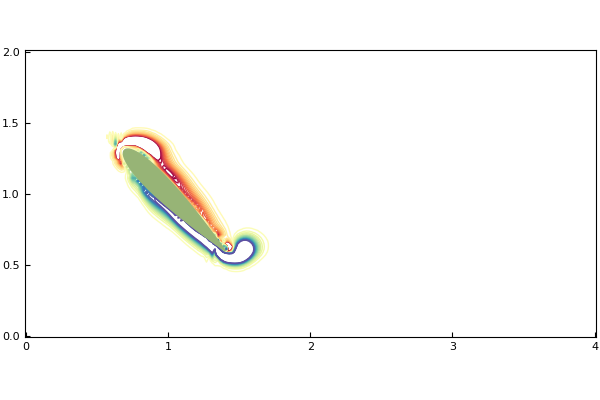

In [18]:
plot(xg,yg,uhist[end],levels=linspace(-0.25,0.25,30))
plot!(body)

Make a movie

In [19]:
@gif for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=linspace(-0.5,0.5,30))
    plot!(body)
end

INFO: Saved animation to /mnt/g/Research/Whirl.jl/examples/tmp.gif


Plots.AnimatedGif("/mnt/g/Research/Whirl.jl/examples/tmp.gif")

In [20]:
fx

2000-element Array{Float64,1}:
 -6144.46    
     2.36301 
     2.3533  
     2.34369 
     2.33415 
     2.32468 
     2.31527 
     2.30594 
     2.29667 
     2.28747 
     2.27833 
     2.26927 
     2.26026 
     ⋮       
     0.874371
     0.874355
     0.874339
     0.874323
     0.874307
     0.874291
     0.874275
     0.874259
     0.874243
     0.874227
     0.874211
     0.874194

In [21]:
fy

2000-element Array{Float64,1}:
 -4427.48    
     1.35283 
     1.34565 
     1.33851 
     1.33143 
     1.32441 
     1.31745 
     1.31056 
     1.30372 
     1.29694 
     1.29021 
     1.28355 
     1.27694 
     ⋮       
     0.845103
     0.845209
     0.845314
     0.845419
     0.845525
     0.84563 
     0.845735
     0.84584 
     0.845945
     0.846049
     0.846154
     0.846259


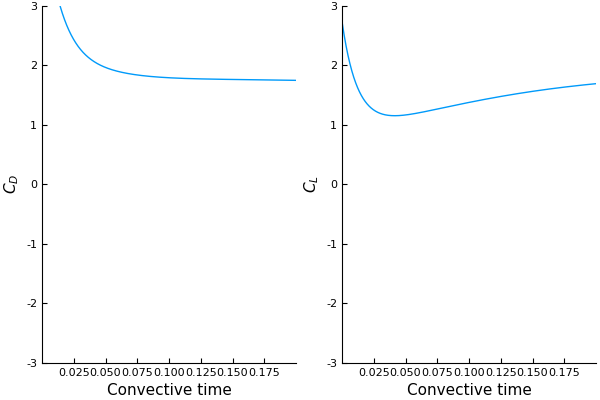

In [22]:
px = plot(thist,2*fx,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)


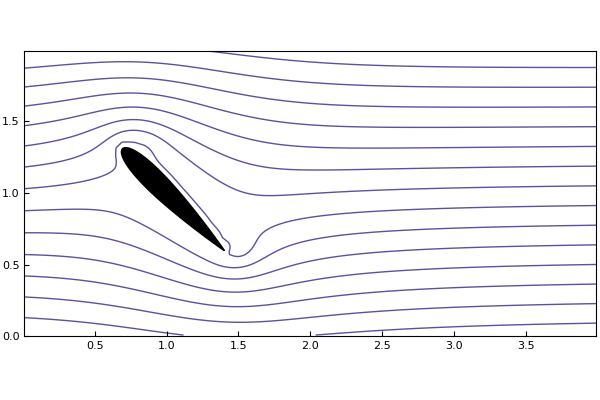

In [23]:
xg,yg = coordinates(u,dx=Δx)
ψ = deepcopy(u)
ψ .= -(sys.L\u)*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)